In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Импортируем все необходимые библиотеки ##

In [2]:
!pip install -qqq ipyplot

In [3]:
import os
import numpy as np 
import pandas as pd 
import glob
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import random
from ipyplot import plot_images

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = '/kaggle/input/shift-cv-winter-2023/train/train/'

In [4]:
import random 
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Классы и функции для загрузки данных ##

In [5]:
def read_image(path: str):  
    return cv2.imread(path)


class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    
class CustomDatasetTrainVal(CustomDataset):
    def __init__(self, df: pd.DataFrame, transform: transforms.Compose=None) -> None:
        super().__init__(df)
        self.transform = transform
    
    def __getitem__(self, idx: int):  
        image_path = self.df.filename.iloc[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.df.blur.iloc[idx]
        return {
            "image": image,
            "label": label,
            "path": image_path
        }


class CustomDatasetTest(CustomDataset):
    def __init__(self, df: pd.DataFrame, transform: transforms.Compose=None) -> None:
        super().__init__(df)
        self.transform = transform
    
    def __getitem__(self, idx: int):
        image_path = self.df.filename.iloc[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return {
            "image": image
        }

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Загружаем данные ##

In [7]:
df_train = pd.read_csv('/kaggle/input/shift-cv-winter-2023/train.csv')
df_train['filename'] = df_train['filename'].apply(lambda x: path + x)

test_imgs = []
for file in glob.glob("/kaggle/input/shift-cv-winter-2023/test/test/*.jpg"):
    test_imgs.append({'filename': file})
df_test = pd.DataFrame(test_imgs)

df_train_, df_val_ = train_test_split(df_train, test_size=0.1, stratify=df_train.blur.values, random_state=SEED)

train_dataset = CustomDatasetTrainVal(df_train_, transform=train_transforms)
val_dataset = CustomDatasetTrainVal(df_val_, transform=test_transforms)
test_dataset = CustomDatasetTest(df_test, transform=test_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16)

## Определим функции для обучения и оценки моделей ##

In [8]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, shed=None, device=torch.device("cpu"), info=True, mod_name='tut3-model.pt'):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    auc_val_list = []
    min_auc = 0
    min_val_loss = np.inf
    
    for epoch in range(epochs):
        model.train()
        
        loss_sum_train = 0
        loss_sum_val = 0
        correct = 0
        num = 0
        for_auc = []
        for_auc_true = []
        
        for batch in tqdm(train_dl):
            xb, yb = batch["image"].to(device), batch["label"].to(device)
            # xb = xb.permute(0, 3, 1, 2)
            
            xb = xb.float()
            res = model(xb)
            
            loss = loss_func(res.squeeze(), yb)
            loss_sum_train += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if shed:
            shed.step()
            
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_dl):
                xb, yb = batch["image"].to(device), batch["label"].to(device)
                # xb = xb.permute(0, 3, 1, 2)
                
                xb = xb.float()
                res = model(xb)
                
                res = res.squeeze()
                
                for_auc.extend(res.tolist())
                for_auc_true.extend(yb.tolist())
                loss_sum_val += loss_func(res, yb).item()
                preds = (F.sigmoid(res) > 0.5).int()
                correct += (preds == yb).sum().item()
                num += len(xb)
        
        curr_auc = roc_auc_score(for_auc_true, for_auc)
        
        print(f"***TRAIN LOSSES - {loss_sum_train / len(train_dl)}***")
        print(f"***VAL LOSSES - {loss_sum_val / len(valid_dl)}***")
        print(f"***ACCURACY - {correct / num}***")
        print(f"***AUC - {curr_auc}***")
        
        train_losses.append(loss_sum_train / len(train_dl))
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
        auc_val_list.append(curr_auc)
        
        if curr_auc > min_auc:
            torch.save(model.state_dict(), mod_name)
            min_auc = curr_auc
            if min_auc == 1.0:
                break
        
    return train_losses, val_losses, valid_accuracies, auc_val_list


def eval(model, valid_dl, device):
    model.eval()
    
    probs = []
    labels = []
    imgs_paths = []
    
    with torch.no_grad():
        for batch in tqdm(valid_dl):
            xb, yb, pth = batch["image"].to(device), batch["label"].to(device), batch["path"]
            
            xb = xb.float()
            res = model(xb)
            res = res.squeeze()
            probs.extend((F.sigmoid(res)).tolist())
            labels.extend(yb.tolist())
            imgs_paths.extend(pth)
            
    return np.array(probs), np.array(labels), np.array(imgs_paths)


def print_false_negative(model, val_dataloader, device):
    probs, labels, imgs_paths = eval(model, val_dataloader, device)
    k1 = probs < 0.5
    k2 = labels == 1
    fn = k1 & k2
    try:
        plot_images(imgs_paths[fn], max_images=10, img_width=600, force_b64=True)
    except:
        print("Ошибки данного рода отсутствуют на валидационном наборе")


def print_false_positive(model, val_dataloader, device):
    probs, labels, imgs_paths = eval(model, val_dataloader, device)
    k1 = probs >= 0.5
    k2 = labels == 0
    fp = k1 & k2
    try:
        plot_images(imgs_paths[fp], max_images=10, img_width=600, force_b64=True)
    except:
        print("Ошибки данного рода отсутствуют на валидационном наборе")   

## Обучим модели ##

### densenet121 ###

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


***TRAIN LOSSES - 0.3870571446704756***
***VAL LOSSES - 0.14567260574332583***
***ACCURACY - 0.9737827715355806***
***AUC - 0.9954519932622122***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


***TRAIN LOSSES - 0.18575698348858108***
***VAL LOSSES - 0.07601097805203448***
***ACCURACY - 0.9850187265917603***
***AUC - 0.9982594048287479***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


***TRAIN LOSSES - 0.14044076712842493***
***VAL LOSSES - 0.057729559902694***
***ACCURACY - 0.9925093632958801***
***AUC - 0.99842784952274***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


***TRAIN LOSSES - 0.11541634876776366***
***VAL LOSSES - 0.045873660078167115***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9991577765300392***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


***TRAIN LOSSES - 0.07852526262226592***
***VAL LOSSES - 0.04786063928379486***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9991577765300392***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


***TRAIN LOSSES - 0.07338928715659246***
***VAL LOSSES - 0.03732235109779072***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9995508141493543***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


***TRAIN LOSSES - 0.06751529885938158***
***VAL LOSSES - 0.0403147340541441***
***ACCURACY - 0.9887640449438202***
***AUC - 0.999606962380685***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


***TRAIN LOSSES - 0.05491545971358318***
***VAL LOSSES - 0.03856391117106736***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9993823694553622***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.15it/s]


***TRAIN LOSSES - 0.04683526422893498***
***VAL LOSSES - 0.03166308494989196***
***ACCURACY - 0.9887640449438202***
***AUC - 0.999606962380685***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.25it/s]


***TRAIN LOSSES - 0.04313493891471553***
***VAL LOSSES - 0.034983379145259896***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9997754070746772***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


***TRAIN LOSSES - 0.03838194150779866***
***VAL LOSSES - 0.0404863587420988***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9994946659180236***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.15it/s]


***TRAIN LOSSES - 0.030140799118977844***
***VAL LOSSES - 0.04983790651143188***
***ACCURACY - 0.9850187265917603***
***AUC - 0.9977540707467715***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


***TRAIN LOSSES - 0.03305831418104046***
***VAL LOSSES - 0.025834572704663095***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9996631106120157***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.15it/s]


***TRAIN LOSSES - 0.025012098272029732***
***VAL LOSSES - 0.020951986959773263***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9998315553060079***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.16it/s]


***TRAIN LOSSES - 0.03264943595599652***
***VAL LOSSES - 0.040681832010740604***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9979786636720943***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


***TRAIN LOSSES - 0.027063841355523154***
***VAL LOSSES - 0.022359102595296027***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9997754070746772***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.11it/s]


***TRAIN LOSSES - 0.04216087352601584***
***VAL LOSSES - 0.042946012189860897***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9988208871420551***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


***TRAIN LOSSES - 0.025831896169337825***
***VAL LOSSES - 0.021856828577809767***
***ACCURACY - 0.9962546816479401***
***AUC - 0.9996069623806849***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.11it/s]


***TRAIN LOSSES - 0.02752547856158672***
***VAL LOSSES - 0.027507738982581048***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9993823694553621***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


***TRAIN LOSSES - 0.03223402774324336***
***VAL LOSSES - 0.029530643836616664***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9999438517686693***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.08it/s]



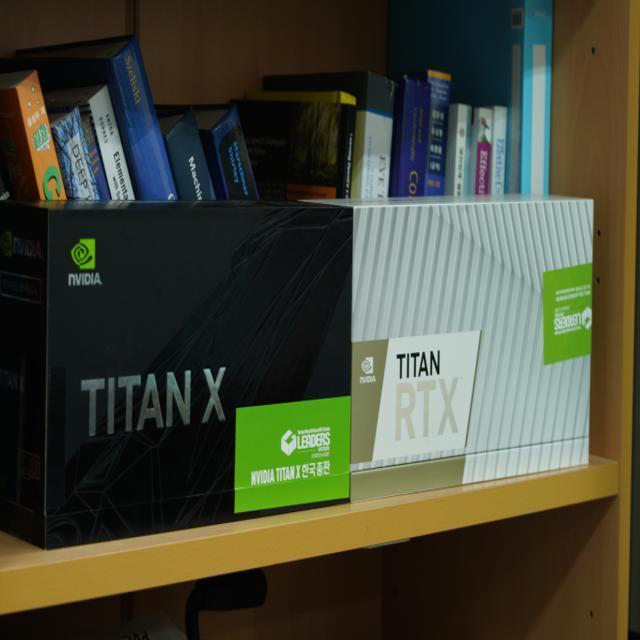


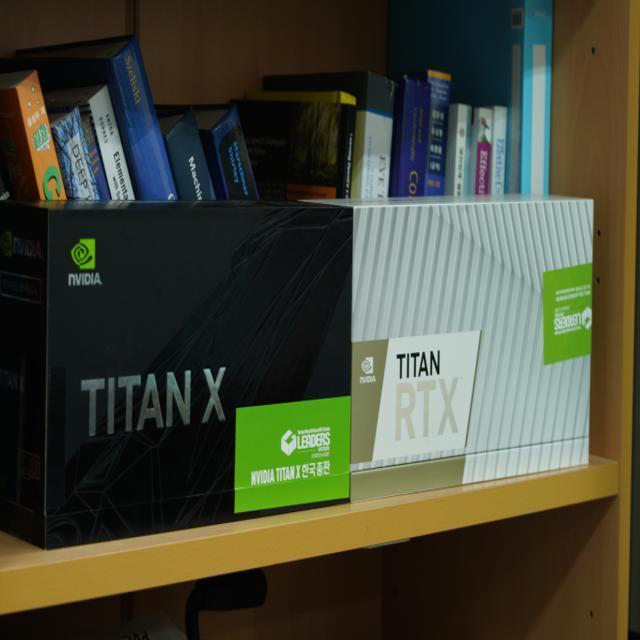

In [9]:
model_1 = models.densenet121(pretrained=True)
model_1.classifier = nn.Linear(1024, 1)

model_1.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model_1.parameters(), lr=1e-5)
scheduler = None

info = fit(20, model_1, criterion, optimizer, train_dataloader, val_dataloader, scheduler, device, True, "model_1.pt")

print_false_negative(model_1, val_dataloader, device)

In [10]:
model_1.load_state_dict(torch.load('model_1.pt'))

<All keys matched successfully>

100%|██████████| 34/34 [00:07<00:00,  4.27it/s]



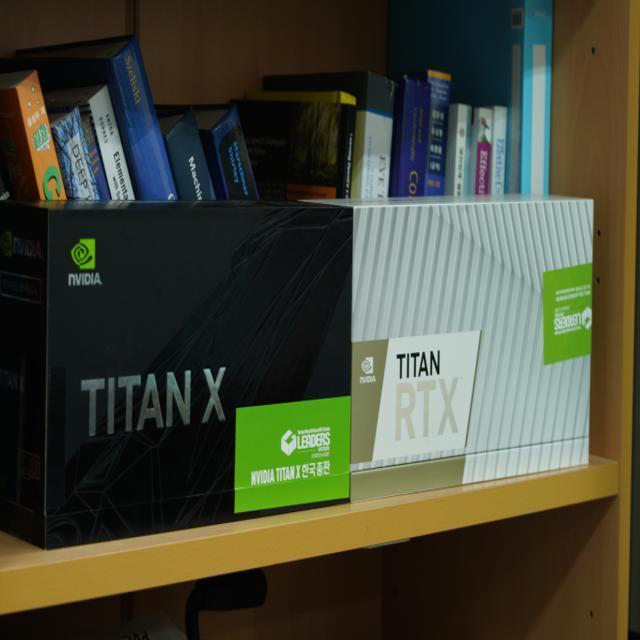


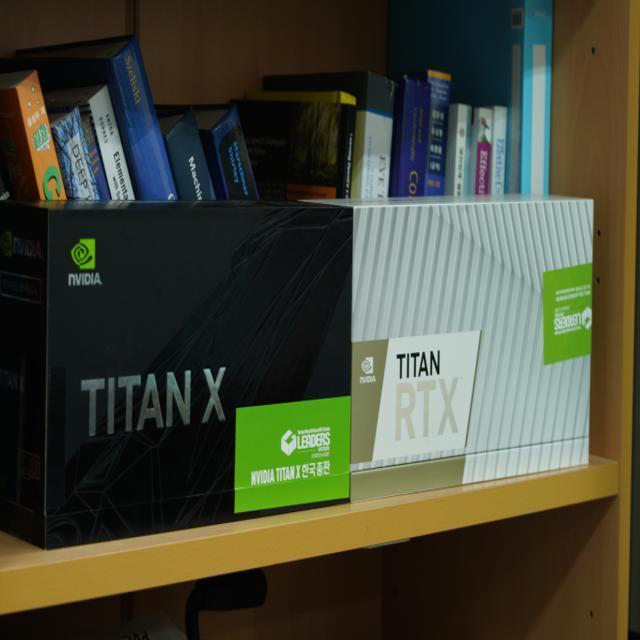

In [11]:
print_false_negative(model_1, val_dataloader, device)

100%|██████████| 34/34 [00:07<00:00,  4.43it/s]



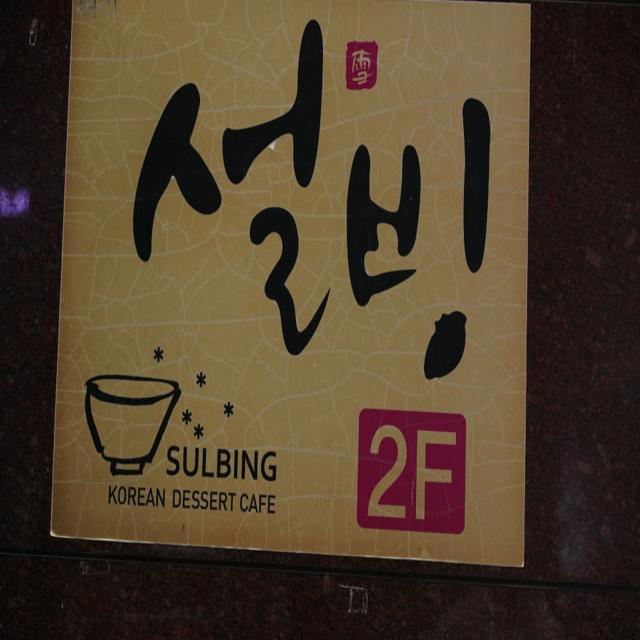


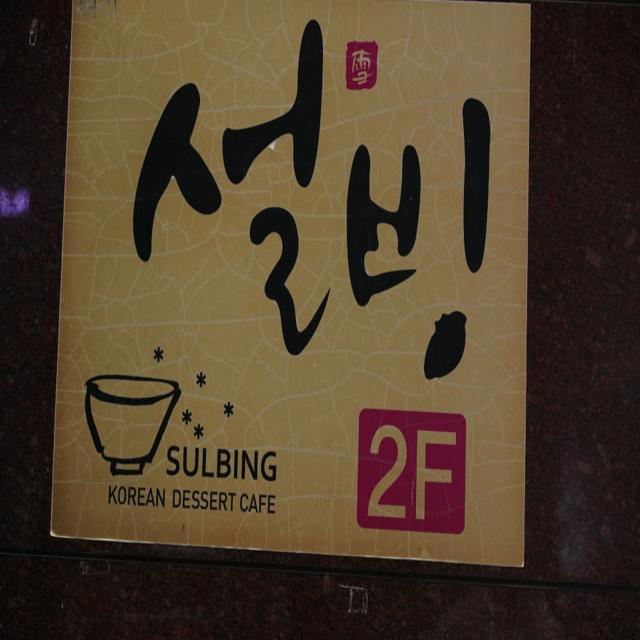

In [12]:
print_false_positive(model_1, val_dataloader, device)

### efficientnet_b2 ###

In [13]:
model_2 = models.efficientnet_b2(pretrained=True)
model_2.classifier[-1] = nn.Linear(1408, 1)

model_2.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model_2.parameters(), lr=1e-5)
scheduler = None

info = fit(20, model_2, criterion, optimizer, train_dataloader, val_dataloader, scheduler, device, True, "model_2.pt")



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


***TRAIN LOSSES - 0.5940272623284254***
***VAL LOSSES - 0.4474282930490981***
***ACCURACY - 0.8876404494382022***
***AUC - 0.9819202695115105***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


***TRAIN LOSSES - 0.33127850368395834***
***VAL LOSSES - 0.1946867128204116***
***ACCURACY - 0.9588014981273408***
***AUC - 0.993542953396968***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


***TRAIN LOSSES - 0.2121408670233638***
***VAL LOSSES - 0.12458524551513227***
***ACCURACY - 0.9775280898876404***
***AUC - 0.9977540707467715***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


***TRAIN LOSSES - 0.1732661899834381***
***VAL LOSSES - 0.09406065776937678***
***ACCURACY - 0.9812734082397003***
***AUC - 0.9980909601347556***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


***TRAIN LOSSES - 0.15718932196140456***
***VAL LOSSES - 0.06528390495616929***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9994385176866929***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.06it/s]


***TRAIN LOSSES - 0.12692375934444794***
***VAL LOSSES - 0.06818797281933112***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9989893318360472***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


***TRAIN LOSSES - 0.12352784189840814***
***VAL LOSSES - 0.05047526437155737***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9993262212240315***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


***TRAIN LOSSES - 0.08310612873257826***
***VAL LOSSES - 0.03550955413142137***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9997754070746772***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


***TRAIN LOSSES - 0.07882787939793025***
***VAL LOSSES - 0.03940748125758529***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9995508141493543***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


***TRAIN LOSSES - 0.09920915499600914***
***VAL LOSSES - 0.03297853023595629***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9997754070746772***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


***TRAIN LOSSES - 0.07676498202001047***
***VAL LOSSES - 0.034501049159844775***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9996631106120157***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


***TRAIN LOSSES - 0.06421576679313466***
***VAL LOSSES - 0.028420381267611042***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9998315553060079***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


***TRAIN LOSSES - 0.08098241110566227***
***VAL LOSSES - 0.035124236952814046***
***ACCURACY - 0.9925093632958801***
***AUC - 0.999606962380685***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


***TRAIN LOSSES - 0.07713725235382057***
***VAL LOSSES - 0.027311159147191066***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9998877035373386***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


***TRAIN LOSSES - 0.05071457142444849***
***VAL LOSSES - 0.028992670900536536***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9997192588433464***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


***TRAIN LOSSES - 0.03984137298078894***
***VAL LOSSES - 0.02811538018084097***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9997192588433464***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


***TRAIN LOSSES - 0.05469711626359655***
***VAL LOSSES - 0.030805952385452504***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9994946659180236***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


***TRAIN LOSSES - 0.046288433904280404***
***VAL LOSSES - 0.0336448584232966***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9990454800673779***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


***TRAIN LOSSES - 0.04030626815236796***
***VAL LOSSES - 0.03675077286376928***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9987085906793937***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:05<00:00,  5.67it/s]

***TRAIN LOSSES - 0.06974578977171669***
***VAL LOSSES - 0.03288871476370568***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9993823694553622***


In [14]:
model_2.load_state_dict(torch.load('model_2.pt'))

<All keys matched successfully>

  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:06<00:00,  5.41it/s]



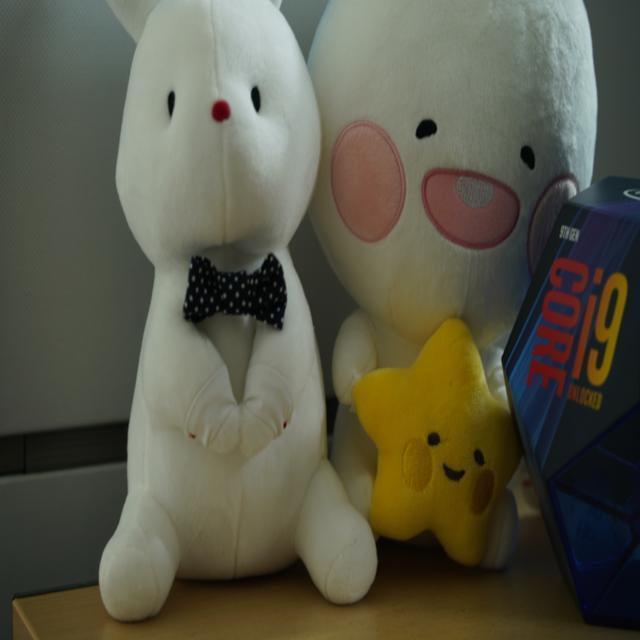
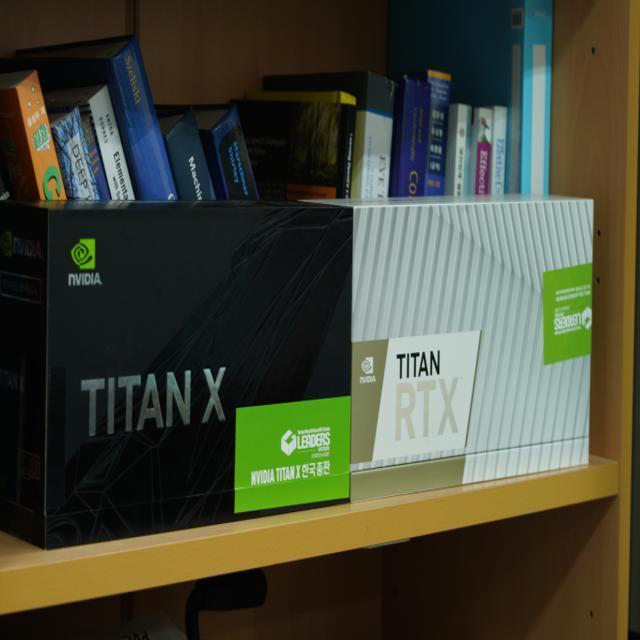


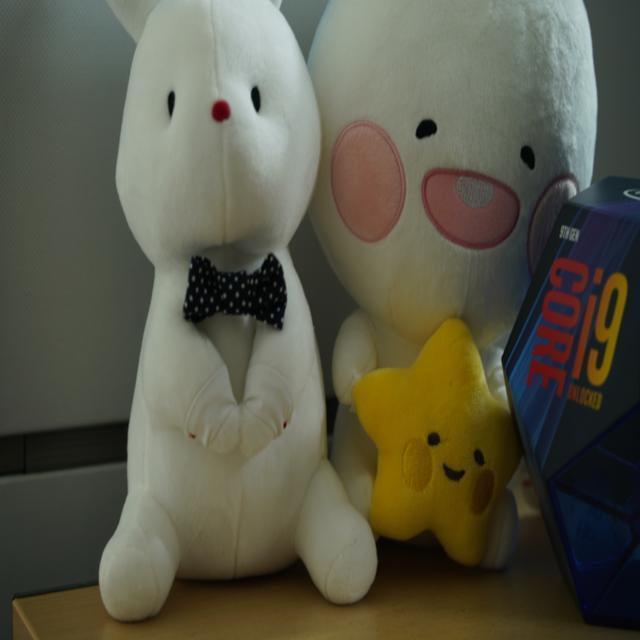
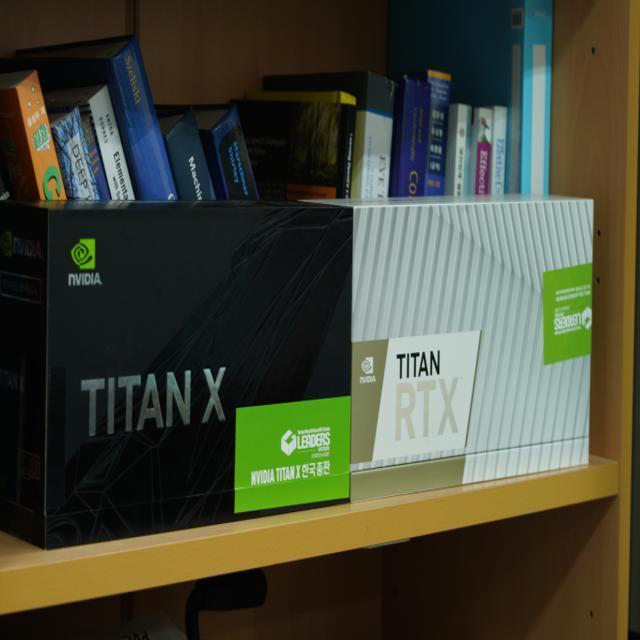

In [15]:
print_false_negative(model_2, val_dataloader, device)

100%|██████████| 34/34 [00:06<00:00,  5.46it/s]



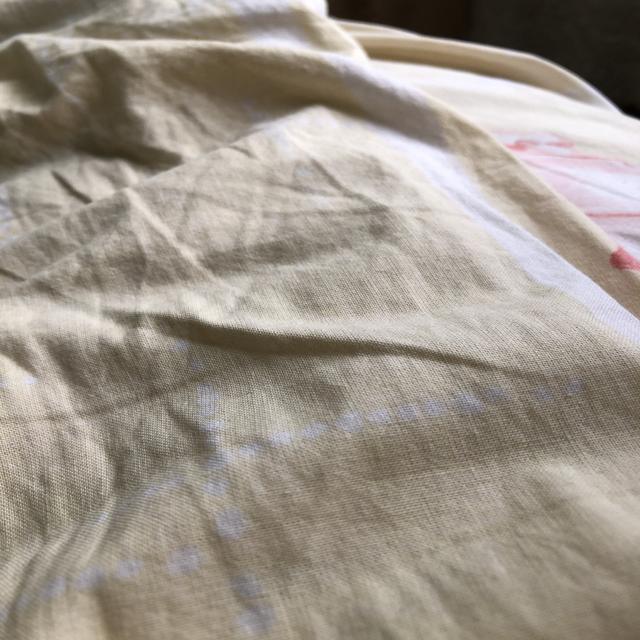


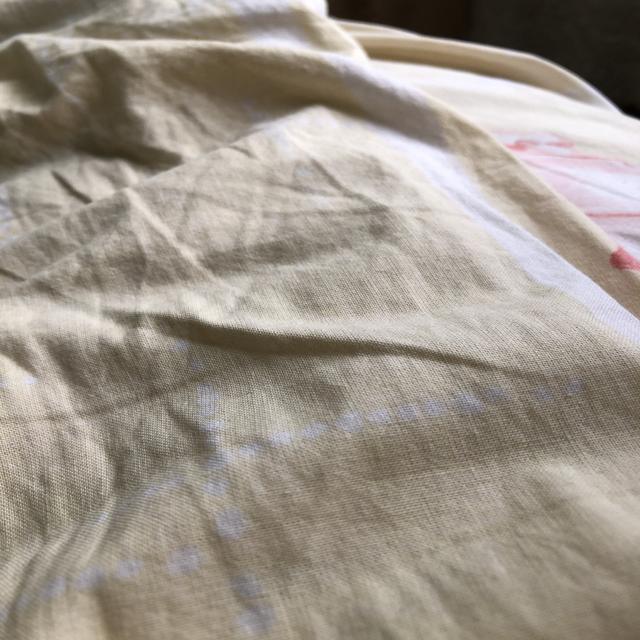

In [16]:
print_false_positive(model_2, val_dataloader, device)

### regnet_y_1_6gf ###

In [17]:
model_3 = models.regnet_y_1_6gf(pretrained=True)
model_3.fc = nn.Linear(888, 1)

model_3.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model_3.parameters(), lr=1e-5)
scheduler = None

info = fit(20, model_3, criterion, optimizer, train_dataloader, val_dataloader, scheduler, device, True, "model_3.pt")



Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-b11a554e.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-b11a554e.pth


  0%|          | 0.00/43.2M [00:00<?, ?B/s]

100%|██████████| 34/34 [00:07<00:00,  4.34it/s]


***TRAIN LOSSES - 0.42119050678556474***
***VAL LOSSES - 0.16174588213656463***
***ACCURACY - 0.9737827715355806***
***AUC - 0.9956765861875351***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.46it/s]


***TRAIN LOSSES - 0.18892919412028764***
***VAL LOSSES - 0.07057192315080422***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9994946659180235***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.29it/s]


***TRAIN LOSSES - 0.1314801731509556***
***VAL LOSSES - 0.046054156826518436***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9994946659180235***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


***TRAIN LOSSES - 0.1041868870162887***
***VAL LOSSES - 0.03727022958999744***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9998877035373386***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.30it/s]


***TRAIN LOSSES - 0.0860169426653081***
***VAL LOSSES - 0.03216259372540836***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9998315553060079***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.54it/s]


***TRAIN LOSSES - 0.07133168864281036***
***VAL LOSSES - 0.028689587480134466***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9998877035373386***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.54it/s]


***TRAIN LOSSES - 0.06762053734473047***
***VAL LOSSES - 0.027234703061294087***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9998877035373386***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.48it/s]


***TRAIN LOSSES - 0.043564825426409805***
***VAL LOSSES - 0.02838143651539225***
***ACCURACY - 0.9887640449438202***
***AUC - 0.9998877035373386***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.61it/s]


***TRAIN LOSSES - 0.056015475632578325***
***VAL LOSSES - 0.02225208939950856***
***ACCURACY - 0.9962546816479401***
***AUC - 0.9999438517686693***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.52it/s]


***TRAIN LOSSES - 0.04184906411084032***
***VAL LOSSES - 0.020940058155161936***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9999438517686693***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.58it/s]


***TRAIN LOSSES - 0.04537308907419756***
***VAL LOSSES - 0.01771882301099578***
***ACCURACY - 0.9925093632958801***
***AUC - 0.9999438517686693***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.58it/s]


***TRAIN LOSSES - 0.0511500077255545***
***VAL LOSSES - 0.01940681926388063***
***ACCURACY - 0.9962546816479401***
***AUC - 1.0***


In [18]:
model_3.load_state_dict(torch.load('model_3.pt'))

<All keys matched successfully>

  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:07<00:00,  4.55it/s]



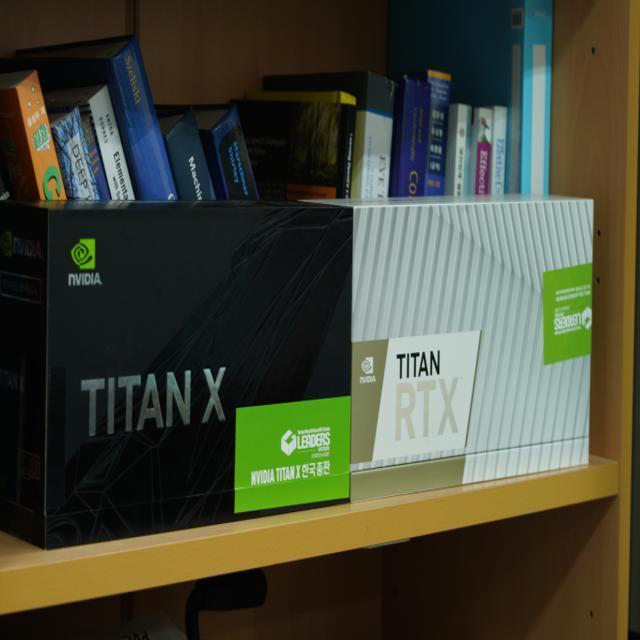


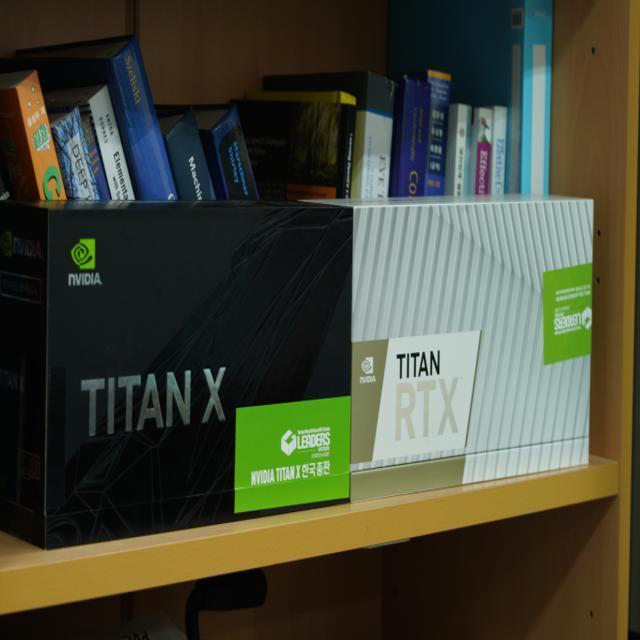

In [19]:
print_false_negative(model_3, val_dataloader, device)

In [20]:
print_false_positive(model_3, val_dataloader, device)

100%|██████████| 34/34 [00:07<00:00,  4.54it/s]

Ошибки данного рода отсутствуют на валидационном наборе


## Модель-ансамбль из трех обученных ранее моделей ##

In [21]:
class myEnsembleModel(nn.Module):
    def __init__(self, model_1, model_2, model_3):
        super(myEnsembleModel, self).__init__()  # хмммм кажется так
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
        self.clf = nn.Linear(3, 1)

    def forward(self, x):
        out_1 = self.model_1(x)
        out_2 = self.model_2(x)
        out_3 = self.model_3(x)
        
        all_out = torch.cat((out_1, out_2, out_3), dim=1)
        out = self.clf(all_out)
        return out

In [22]:
model_1.load_state_dict(torch.load('model_1.pt'))
model_2.load_state_dict(torch.load('model_2.pt'))
model_3.load_state_dict(torch.load('model_3.pt'))

final_model = myEnsembleModel(model_1, model_2, model_3)

# заморозим все кроме последнего слоя
for param in final_model.parameters():
    param.requires_grad = False

for param in final_model.clf.parameters():
    param.requires_grad = True

final_model.to(device);

In [23]:
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(final_model.parameters())
scheduler = None

info = fit(20, final_model, criterion, optimizer, train_dataloader, val_dataloader, scheduler, device, True, "final_model.pt")



100%|██████████| 34/34 [00:14<00:00,  2.33it/s]


***TRAIN LOSSES - 1.4568428307525823***
***VAL LOSSES - 0.3721850867273044***
***ACCURACY - 0.8689138576779026***
***AUC - 0.9908478382930938***


  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:13<00:00,  2.43it/s]


***TRAIN LOSSES - 0.2129935089477658***
***VAL LOSSES - 0.10914272340610474***
***ACCURACY - 0.9962546816479401***
***AUC - 1.0***


In [24]:
final_model.load_state_dict(torch.load('final_model.pt'))

<All keys matched successfully>

In [25]:
print_false_negative(final_model, val_dataloader, device)

  0%|          | 0/34 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 34/34 [00:14<00:00,  2.42it/s]

Ошибки данного рода отсутствуют на валидационном наборе


100%|██████████| 34/34 [00:13<00:00,  2.44it/s]



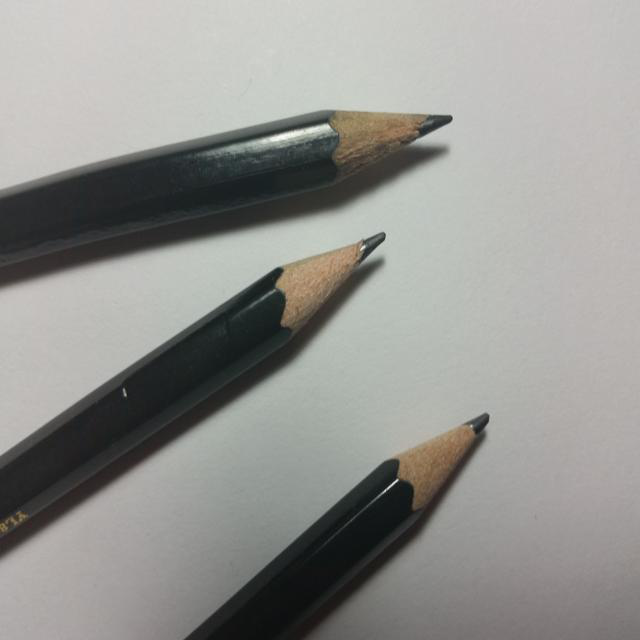


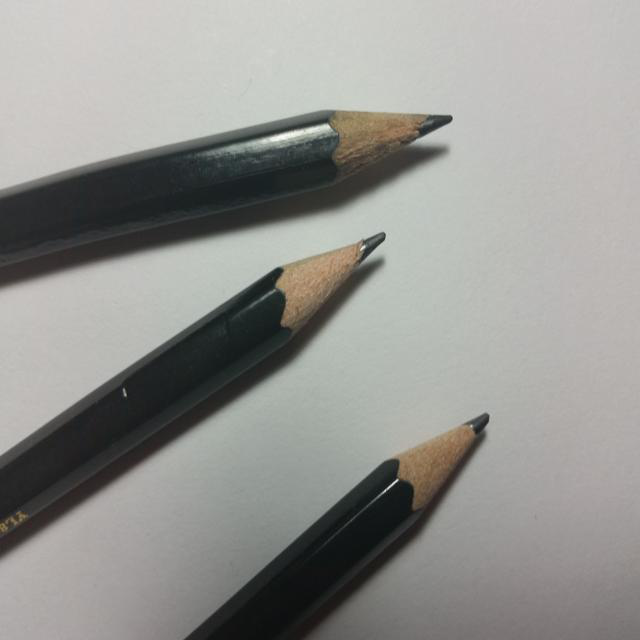

In [26]:
print_false_positive(final_model, val_dataloader, device)

## Обрабатываем тестовый набор данных ##

In [27]:
predicts = []

final_model.load_state_dict(torch.load('final_model.pt'))
final_model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        xb = batch["image"].to(device)
        
        # xb = xb.permute(0, 3, 1, 2)
        
        xb = xb.float()
                
        res = final_model(xb)
                
        res = res.squeeze()
        res = F.sigmoid(res)
        
        predicts.extend(res.tolist())
        
df_test['blur'] = predicts
df_test['filename'] = df_test['filename'].apply(lambda x : os.path.split(x)[1])
df_test.to_csv('/kaggle/working/submission1121.csv', index=False)

100%|██████████| 49/49 [00:53<00:00,  1.09s/it]
